In [1]:
labelumap="leiden"
GOI="PAX6"
labelcycle=False
plot_names=False
check_markers=False
show_contribution=False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
from IPython.display import display, Markdown

# Add function to skip cell if default value is already present
#%load_ext skip_kernel_extension

# Integrated corneal meta-atlas and gene of interest

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Using a try except loop to reduce loading in the dataset again in an active session

try: adata
except NameError: adata = None
    
if adata is None:
    adata=sc.read("data/fullcornea_scVI_postprocessing_labels.h5ad")
    adata.obs['leiden'].cat.reorder_categories(["6","3","2","8","0","9","1","12","18","4","7","10","11","5","13","15","16","14","17","20","19"], inplace=True)
    adata.obs['leiden'] = adata.obs['leiden'].cat.rename_categories({"6": "6: LSC",
            "3": "3: LESC",
            "2": "2: LE",
            "8": "8: LE",
            "0": "0: Cj",
            "9": "9: Cj",
            "1": "1: CE",
            "12": "12: CE",
            "18": "18: CE",
            "4": "4: CSSC",
            "7": "7: SK",
            "10": "10: SK",
            "11": "11: TSK",
            "5": "5: CF",
            "13": "13: CF",
            "15": "15: EC",
            "16": "16: Ves",
            "14": "14: Mel",
            "17": "17: IC",
            "20": "20: nm-cSC",
            "19": "19: MF",
        })
else:
    None

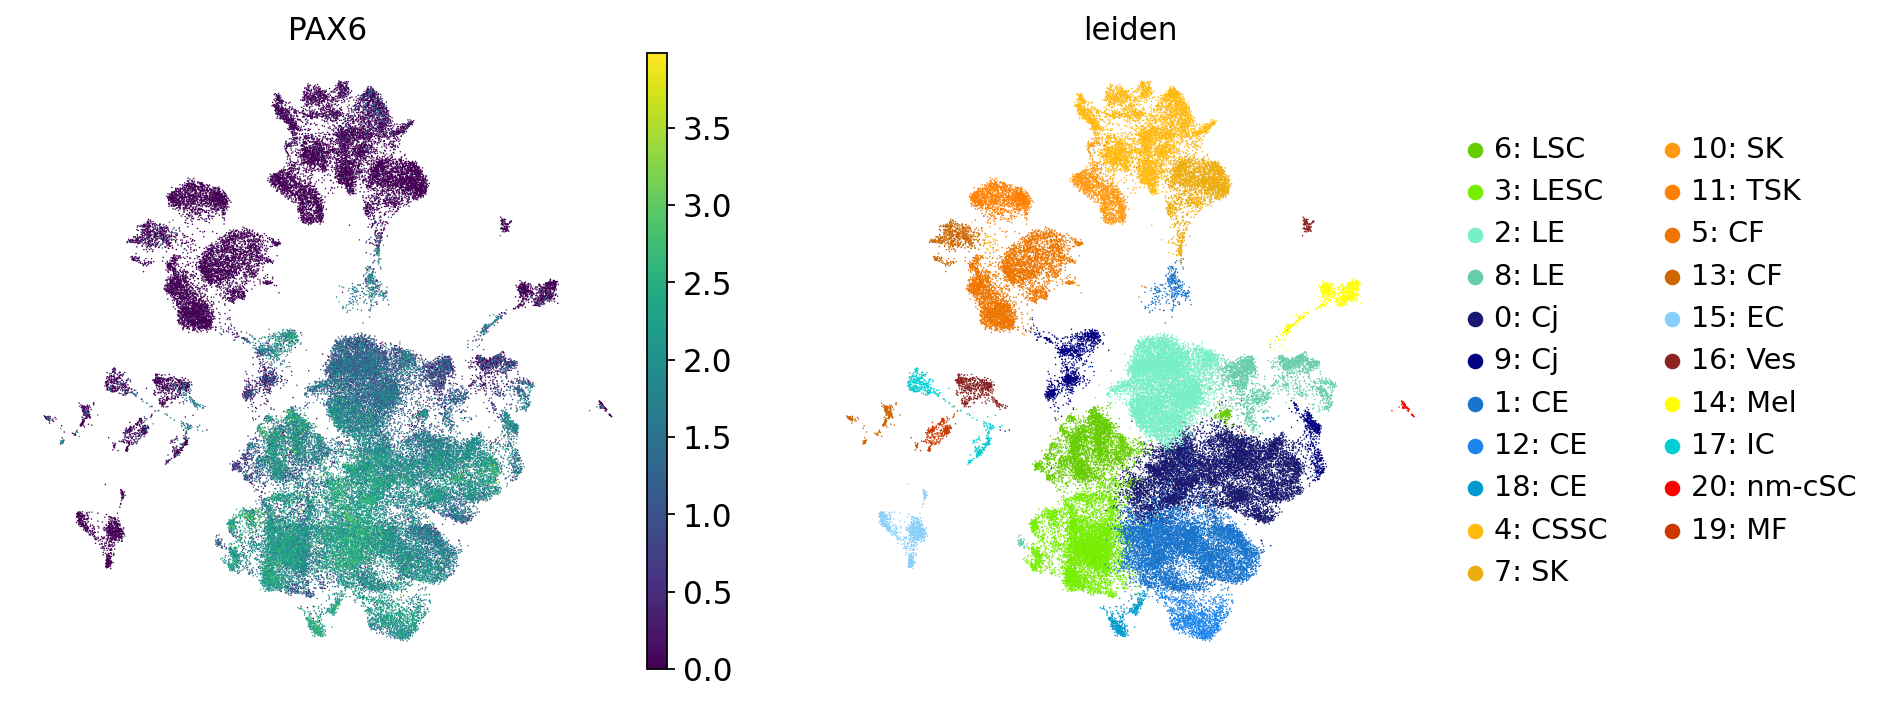

In [4]:
sc.set_figure_params(figsize=(5, 5))
if plot_names==True:
    loc_leg='on data'
    font_size=6.2
else:
    loc_leg='right margin'
    font_size=None

if labelumap == "leiden":
    sc.pl.umap(
        adata,
        color=[GOI,labelumap], 
        frameon=False,
        ncols=2,
        cmap='viridis',
        legend_loc=loc_leg,
               legend_fontsize=font_size, 
        legend_fontoutline=2,
        palette={
            "6: LSC": "#66CD00",
            "3: LESC": "#76EE00",
            "2: LE": "#76EEC6",
            "8: LE": "#66CDAA",
            "0: Cj": "#191970",
            "9: Cj": "#000080",
            "1: CE": "#1874CD",
            "12: CE": "#1C86EE",
            "18: CE": "#009ACD",
            "4: CSSC": "#FFB90F",
            "7: SK": "#EEAD0E",
            "10: SK": "#FF9912",
            "11: TSK": "#FF7F00",
            "5: CF": "#EE7600",
            "13: CF": "#CD6600",
            "15: EC": "#87CEFA",
            "16: Ves": "#8B2323",
            "14: Mel": "#FFFF00",
            "17: IC": "#00CED1",
            "20: nm-cSC": "#FF0000",
            "19: MF": "#CD3700",
        })
else:
    sc.pl.umap(
        adata,
        color=[GOI,labelumap],
        legend_loc=loc_leg,
        frameon=False,
        cmap='viridis_r',
        ncols=2)

    LSC = Limbal stem cells       LESC = Limbal epithelial stem cells   LE = Limbal epithelium      Cj = Conjunctiva
    CE = Central epithelium       CSSC = Corneal stromal stem cells     SK = Stromal keratocytes
    TSK = Transitioning SK        CF= Corneal Fibroblasts               EC = Endothelial Cells
    Ves= Lymph and blood vessels  Mel= Melanocytes                      IC = Immune cells           MF= Myofibroblasts
    nm-cSC = non-myelinating corneal Schwann cells

# Violin plot of gene of interest

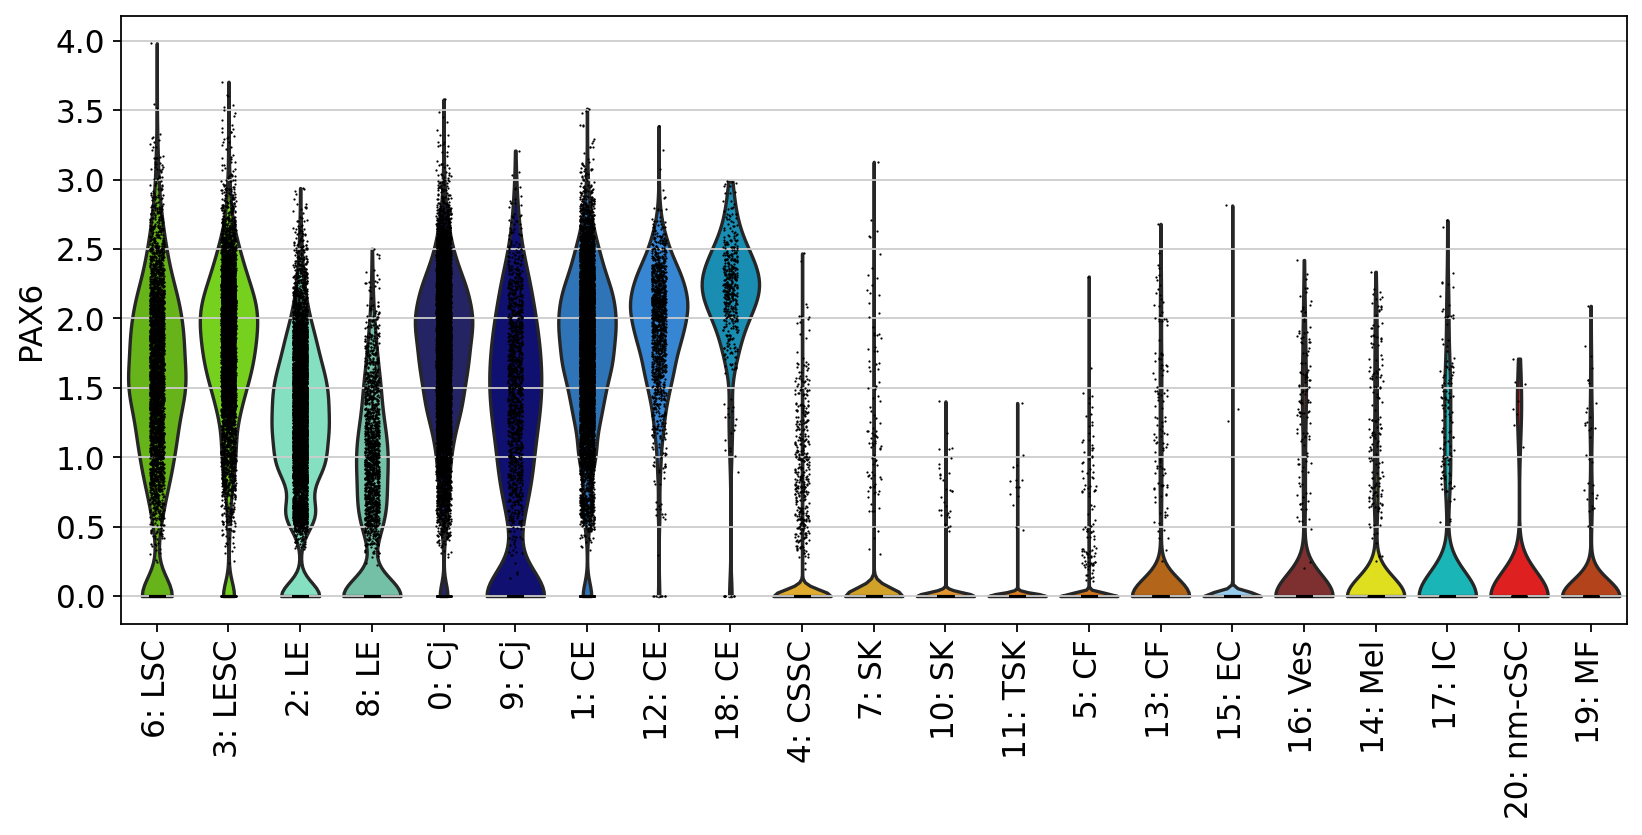

In [15]:
sc.set_figure_params(figsize=(10, 5))
sc.pl.violin(adata, keys=GOI, groupby='leiden', rotation=90)

In [16]:
sc.set_figure_params(figsize=(5, 5))
markers = ["PAX6","KRT14","S100A2","TP63","KRT15","GPHA2","CPVL","CXCL17","MUC1","KRT7",
           "S100A8","KRT3","KRT12","KRT24","AREG","LUM","KERA","CD34","MMP1","MMP2","MMP3","FBLN1","COL1A1","COL5A1","CA3","ACKR1",
           "LYVE1","MITF","CCL3","SOX10","CDH19","NGFR","SCN7A","ACTA2"]
if check_markers==True:
    display(Markdown("""# Marker gene visualisation
        """))
    sc.pl.StackedViolin(adata, markers, groupby='leiden').add_totals().show()
else:
    None

In [22]:
sc.set_figure_params(figsize=(5, 5))
markers_cycle = ["MKI67","TOP2A","PCNA","MCM6"]
if labelcycle==True:
    display(Markdown("""# Cell cycle gene visualisation
        """))
    sc.pl.violin(adata, keys=markers_cycle, groupby='leiden', rotation=90)
else:
    None

In [18]:
if show_contribution == True:
    display(Markdown("""# # Stacked barplots of absolute and relative contributions to corneal cell fates
        """))
    sc.set_figure_params(figsize=(10, 5))
    obs_1 = 'batch'
    obs_2 = 'leiden'

    n_categories = {x : len(adata.obs[x].cat.categories) for x in [obs_1, obs_2]}
    df = adata.obs[[obs_2, obs_1]].values

    obs2_clusters = adata.obs[obs_2].cat.categories.tolist()
    obs1_clusters = adata.obs[obs_1].cat.categories.tolist()

    obs1_to_obs2 = {k: np.zeros(len(obs2_clusters), dtype="i")
                       for k in obs1_clusters}
    obs2_to_obs1 = {k: np.zeros(len(obs1_clusters), dtype="i")
                       for k in obs2_clusters}
    obs2_to_obs1

    for b, l in df:
        obs2_to_obs1[b][obs1_clusters.index(str(l))] += 1
        obs1_to_obs2[l][obs2_clusters.index(str(b))] += 1

    df = pd.DataFrame.from_dict(obs2_to_obs1,orient = 'index').reset_index()
    df = df.set_index(["index"])
    df.columns=obs1_clusters
    df.index.names = ['Cell fate']

    stacked_data = df.apply(lambda x: x*100/sum(x), axis=1)

    fig, ax =plt.subplots(1,2)
    df.plot(kind="bar", stacked=True, ax=ax[0])
    stacked_data.plot(kind="bar", stacked=True, legend = False, ax=ax[1])
    fig.show()
else:
    None